# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [27]:
import math

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [5]:
# Cargar el archivo original
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
df_reviews.sample(5)
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
# Verificar valores faltantes
print(df_reviews.isnull().sum())

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

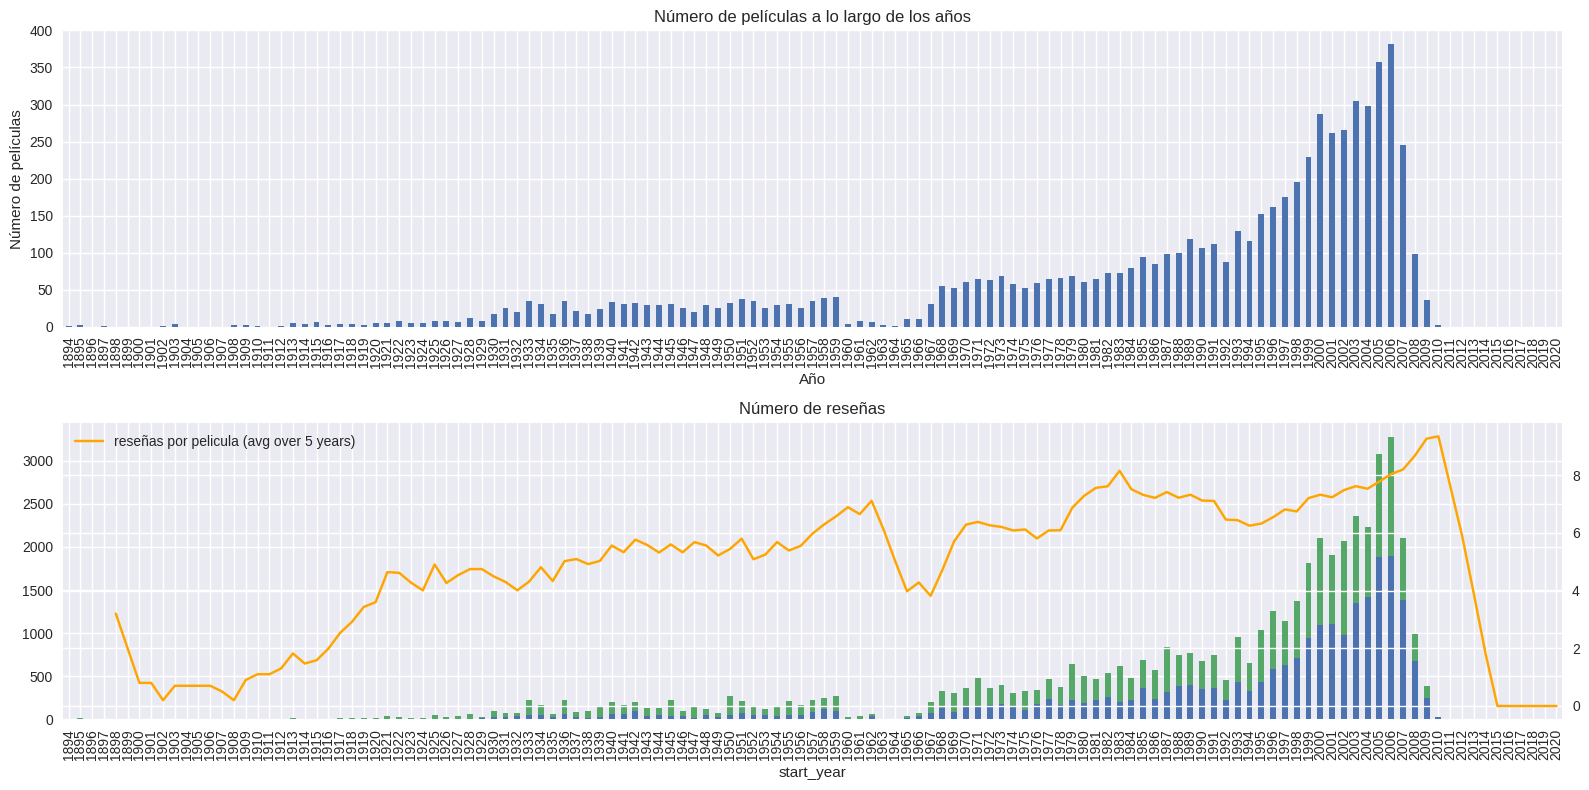

In [8]:
# Crear un subplot con dos gráficos
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Gráfico 1: Número de películas por año
ax = axs[0]
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')
ax.set_xlabel('Año')
ax.set_ylabel('Número de películas')

# Gráfico 2: Número de reseñas (negativas y positivas) por año
ax = axs[1]
dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft2.plot(kind='bar', stacked=True, ax=ax, label=['Negativo', 'Positivo'])

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reseñas por pelicula (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas')
# Ajustar el diseño del gráfico
fig.tight_layout()

# Mostrar el gráfico
plt.show()

La gráfica superior muestra la cantidad de películas producidas a lo largo de los años, evidenciando un aumento significativo a partir de los años 1970 y alcanzando su punto máximo alrededor de 2007, seguido de una disminución. La gráfica inferior combina dos métricas: la línea naranja representa el promedio de reseñas por película calculado en intervalos de cinco años, que muestra un aumento sostenido hasta alcanzar su pico antes de 2005, para luego decaer. Las barras verdes y azules indican, respectivamente, el número de reseñas y películas por año, reflejando una tendencia general similar a la de las producciones cinematográficas. Esto sugiere una relación entre la cantidad de películas producidas y la atención recibida a través de reseñas.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

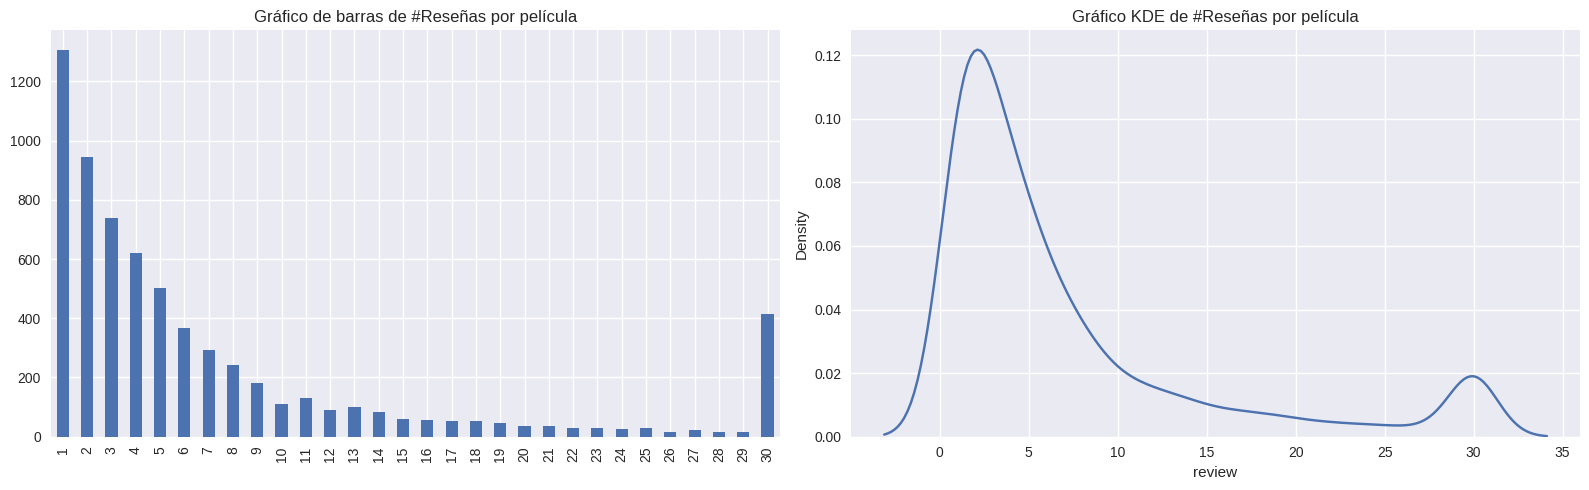

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

La gráfica de la izquierda muestra la cantidad de reseñas por película, donde la mayoría de las películas tienen entre 1 y 3 reseñas, con una disminución notable en las frecuencias conforme aumenta el número de reseñas. Sin embargo, destaca un pico inusual en las películas con exactamente 30 reseñas.

La gráfica de la derecha presenta la misma información, pero de forma más suave mediante una curva de densidad. Se observa que la mayoría de las películas tienen pocas reseñas (1 o 2), y aunque las películas con muchas reseñas son poco frecuentes, existe una excepción notable en torno a las 30 reseñas. Esto refleja que es poco común que una película reciba una gran cantidad de reseñas.

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

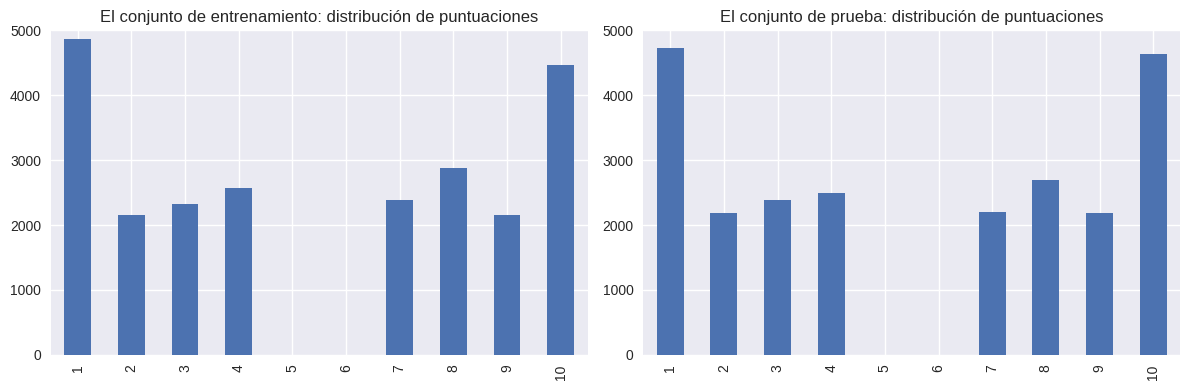

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico para el conjunto de entrenamiento
ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

# Gráfico para el conjunto de prueba
ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()
plt.show()

Las gráficas muestran la distribución de puntuaciones en los conjuntos de entrenamiento (izquierda) y prueba (derecha). En ambos casos, las puntuaciones más comunes son 1 y 10, destacando como los extremos más frecuentes. Las puntuaciones intermedias (2, 3, 4, 7, 8 y 9) tienen frecuencias menores, pero siguen una distribución similar entre los dos conjuntos. Esto indica que los datos están balanceados de manera consistente entre las dos divisiones, manteniendo una proporción similar de puntuaciones en ambas.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


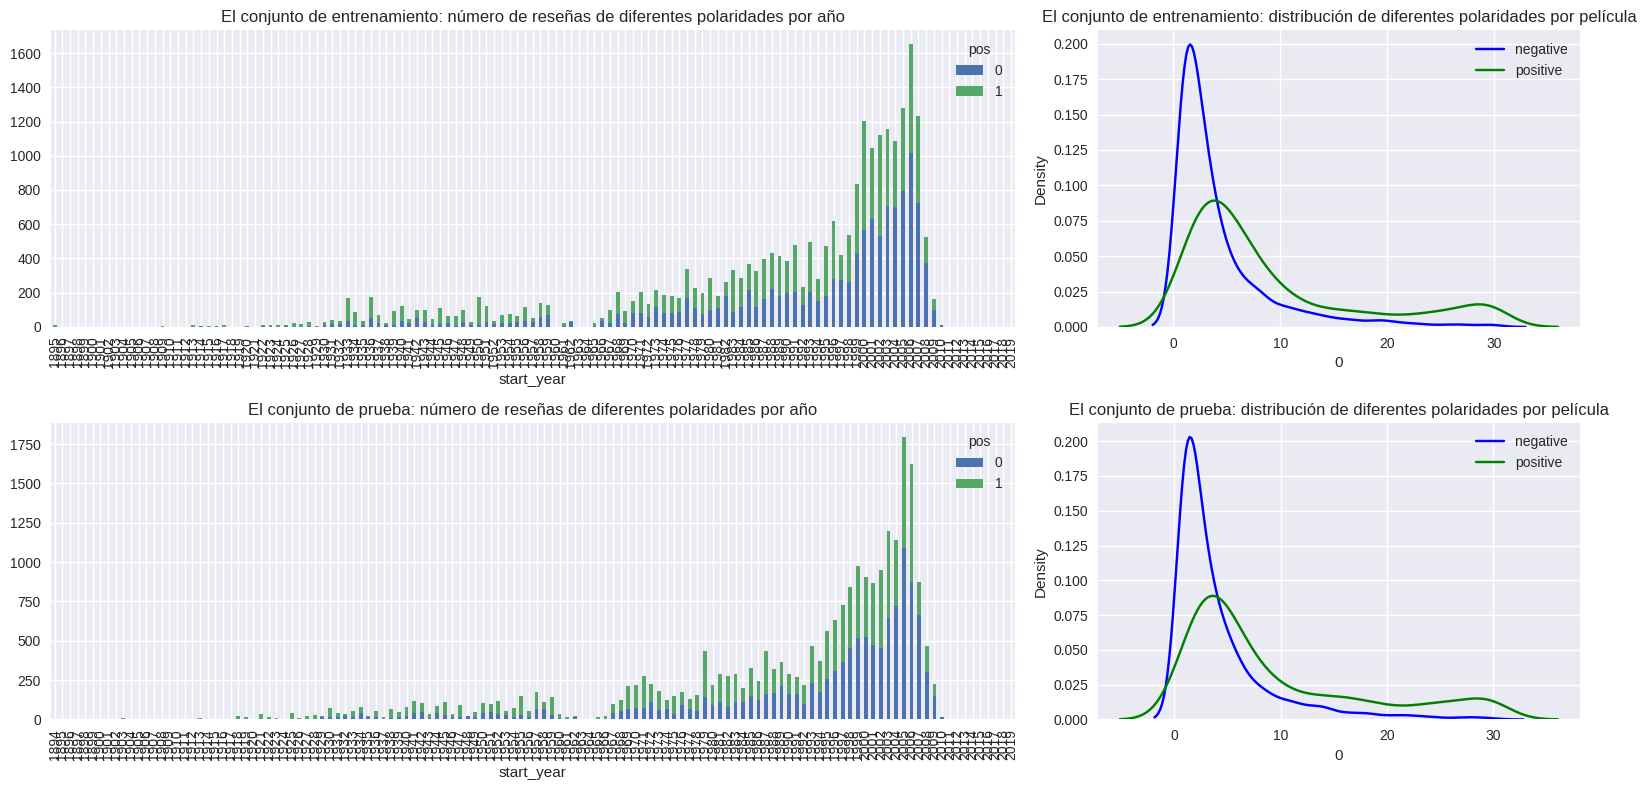

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Las gráficas muestran que las reseñas positivas son más frecuentes que las negativas en ambos conjuntos, con un aumento general en los últimos años. Las reseñas negativas tienden a concentrarse en valores bajos, mientras que las positivas están más distribuidas, indicando una diferencia en cómo se expresan ambas polaridades a lo largo del tiempo y por película.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [13]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [14]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')

In [15]:
print(df_reviews[['review', 'review_norm']].head())

                                              review  \
0  The pakage implies that Warren Beatty and Gold...   
1  How the hell did they get this made?! Presenti...   
2  There is no real story the film seems more lik...   
3  Um .... a serious film about troubled teens in...   
4  I'm totally agree with GarryJohal from Singapo...   

                                         review_norm  
0  the pakage implies that warren beatty and gold...  
1  how the hell did they get this made   presenti...  
2  there is no real story the film seems more lik...  
3  um      a serious film about troubled teens in...  
4  i m totally agree with garryjohal from singapo...  


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [16]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [17]:
from sklearn.dummy import DummyClassifier

In [22]:
# Crear el modelo DummyClassifier con la estrategia 'most_frequent'
dummy_clf = DummyClassifier(strategy='constant', constant=1)

In [23]:
# Entrenar el modelo en el conjunto de entrenamiento
model_0 = dummy_clf.fit(X=df_reviews_train, y=train_target)

           train  test
Exactitud    NaN   NaN
F1          0.67  0.67
APS         0.50  0.50
ROC AUC     0.50  0.50


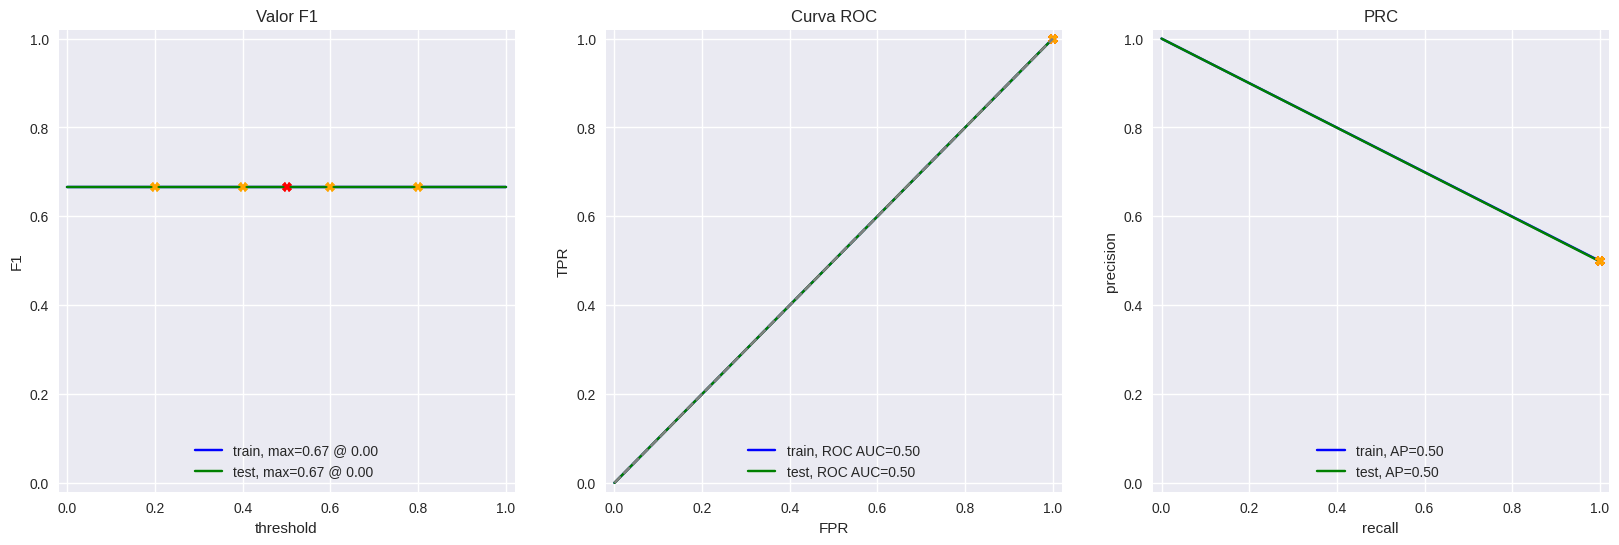

In [24]:
# Evaluar el modelo usando la función evaluate_model
evaluate_model(model_0, np.empty(len(train_target)), train_target, np.empty(len(test_target)), test_target)

Los resultados indican un desempeño bajo del modelo. El valor F1 es 0.67 tanto en el conjunto de entrenamiento como en el de prueba, mientras que las métricas ROC AUC y APS son 0.50, lo que sugiere que el modelo no es mejor que un clasificador aleatorio. Las gráficas de ROC y PRC confirman esta falta de discriminación, ya que las curvas se ajustan a las líneas base, y el gráfico de F1 muestra un desempeño constante sin mejorar con diferentes umbrales.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [25]:
import nltk
from nltk.corpus import stopwords

(23796, 71531)
(23796, 71531)
           train  test
Exactitud    NaN   NaN
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


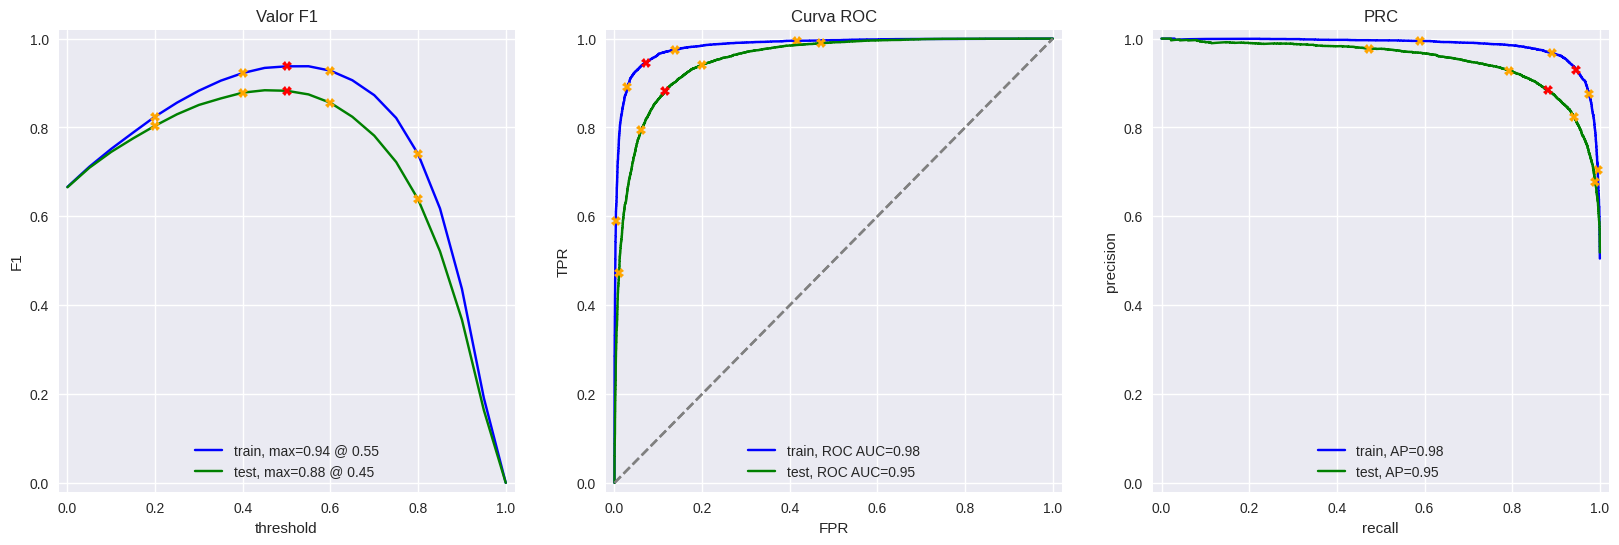

In [28]:
# Configuración del vectorizador TF-IDF con parámetros ajustados
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True)

train_features = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
print(train_features.shape)

test_features = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])
print(train_features.shape)

model_1 = LogisticRegression()

model_1.fit(train_features, train_target)

evaluate_model(model_1, train_features, train_target, test_features, test_target)

Los resultados muestran un buen desempeño del modelo. El valor F1 es 0.94 para el conjunto de entrenamiento y 0.88 para el de prueba, con métricas ROC AUC de 0.98 y 0.95, respectivamente, lo que indica una alta capacidad de discriminación. Las gráficas ROC y PRC reflejan un comportamiento consistente entre ambos conjuntos, con curvas cercanas al óptimo. El gráfico de F1 muestra que el rendimiento se maximiza en umbrales específicos (0.55 para entrenamiento y 0.45 para prueba), confirmando un modelo bien ajustado y generalizable.

### Modelo 3 - spaCy, TF-IDF y LR

In [29]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [30]:
def text_preprocessing_3(text):
    """
    Procesamiento de texto: lematización y eliminación de stop words.
    """
    doc = nlp(text) 
    tokens = [token.lemma_ for token in doc if not token.is_stop]  # Excluir stop words
    return ' '.join(tokens) 

In [31]:
df_reviews_train['review_tokenized_3'] = df_reviews_train['review_norm'].progress_apply(lambda x: text_preprocessing_3(x))
df_reviews_test['review_tokenized_3'] = df_reviews_test['review_norm'].progress_apply(lambda x: text_preprocessing_3(x))

df_reviews_train['review_tokenized_3'].sample(5)
df_reviews_test['review_tokenized_3'].sample(5)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

37526        year old   francis ouimet   shia lebouf   ...
44237    time   troma   company bring cinema classic   ...
46588    s variation oft tell tale people get marry hav...
39400    film cash   cash reliant rouse theme tune crea...
34921    book life like short snack   whet appetite har...
Name: review_tokenized_3, dtype: object

In [32]:
tfidf_vectorizer_3 = TfidfVectorizer()

train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_tokenized_3'])
print(train_features_3.shape)

test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_tokenized_3'])
print(train_features_3.shape)

(23796, 59340)
(23796, 59340)


           train  test
Exactitud    NaN   NaN
F1          0.93  0.87
APS         0.98  0.94
ROC AUC     0.98  0.95


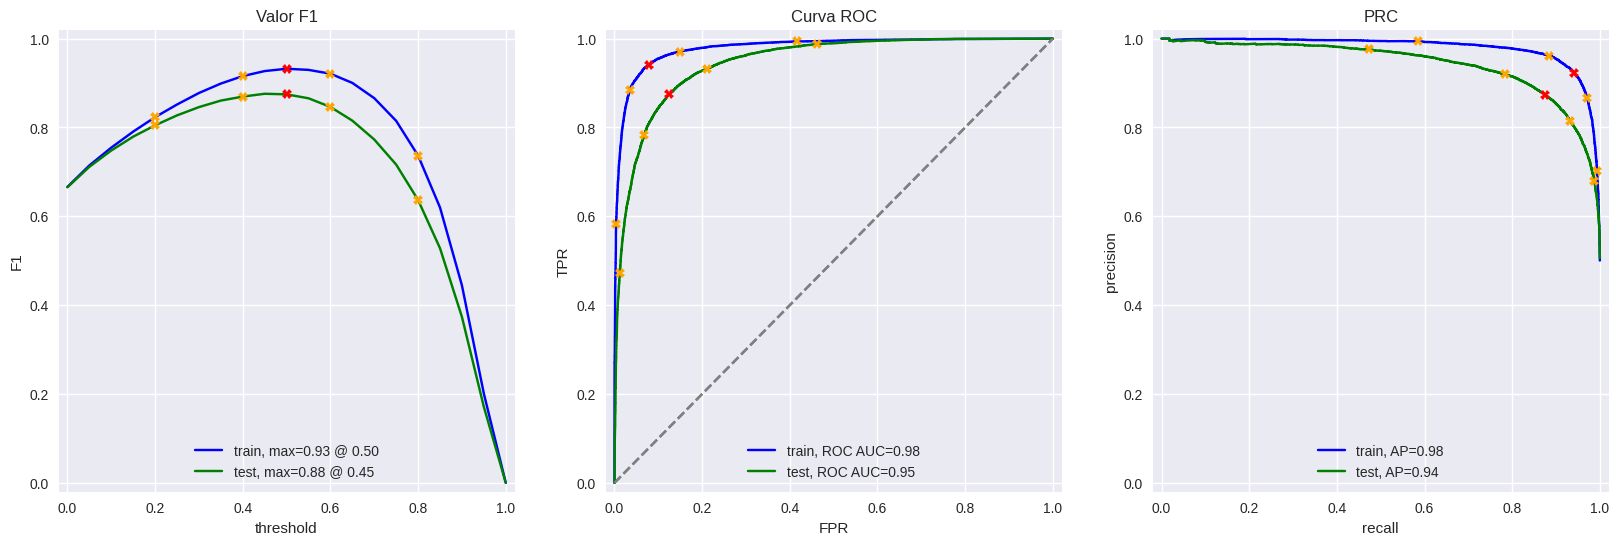

In [33]:
model_3 = LogisticRegression()
model_3.fit(train_features_3, train_target)
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

El modelo muestra un desempeño sólido. El valor F1 es 0.93 en el conjunto de entrenamiento y 0.87 en el de prueba, con métricas ROC AUC de 0.98 y 0.95, respectivamente, indicando buena capacidad de discriminación. Las curvas ROC y PRC reflejan un modelo consistente entre ambos conjuntos, y el gráfico F1 destaca los umbrales óptimos de 0.50 (entrenamiento) y 0.45 (prueba), lo que confirma una buena generalización y equilibrio en el modelo.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [34]:
from lightgbm import LGBMClassifier

In [35]:
model_4 = LGBMClassifier(learning_rate=.1)
model_4.fit(train_features_3, train_target)

LGBMClassifier()

           train  test
Exactitud    NaN   NaN
F1          0.91  0.86
APS         0.97  0.93
ROC AUC     0.97  0.93


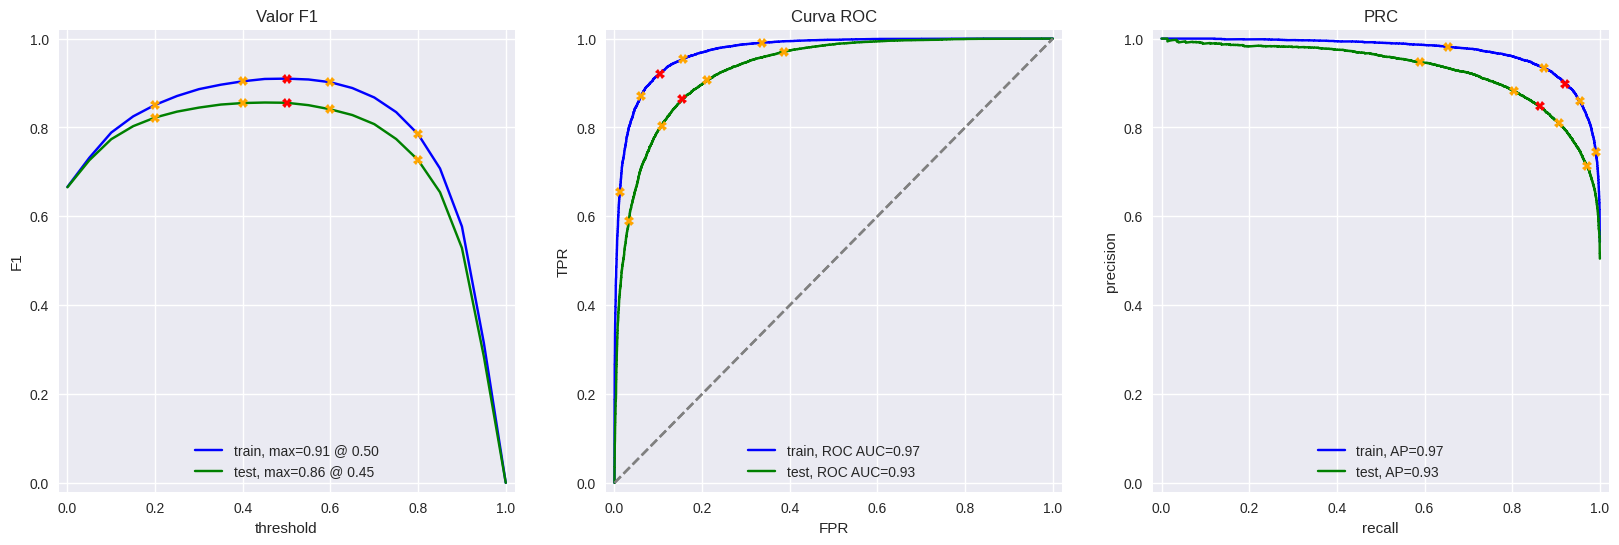

In [36]:
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

El modelo muestra un rendimiento consistente y sólido. El valor F1 es 0.91 en el conjunto de entrenamiento y 0.86 en el de prueba, con métricas ROC AUC de 0.97 y 0.93, respectivamente. Las curvas ROC y PRC son cercanas al óptimo, mostrando una buena capacidad de discriminación. El gráfico de F1 indica que el rendimiento se maximiza en umbrales específicos (0.50 para entrenamiento y 0.45 para prueba), confirmando que el modelo generaliza bien y mantiene un equilibrio adecuado entre precisión y exhaustividad.

## Mis reseñas

In [37]:
# Mis propias reseñas
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# Normalización directa (mismo procedimiento que el conjunto de datos principal)
my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')

# Mostramos las reseñas normalizadas para verificar
print(my_reviews)

                                              review  \
0    I did not simply like it, not my kind of movie.   
1  Well, I was bored and felt asleep in the middl...   
2             I was really fascinated with the movie   
3  Even the actors looked really old and disinter...   
4  I didn't expect the reboot to be so good! Writ...   
5  The movie had its upsides and downsides, but I...   
6  What a rotten attempt at a comedy. Not a singl...   
7  Launching on Netflix was a brave move & I real...   

                                         review_norm  
0    i did not simply like it  not my kind of movie   
1  well  i was bored and felt asleep in the middl...  
2             i was really fascinated with the movie  
3  even the actors looked really old and disinter...  
4  i didn t expect the reboot to be so good  writ...  
5  the movie had its upsides and downsides  but i...  
6  what a rotten attempt at a comedy  not a singl...  
7  launching on netflix was a brave move   i real...  


### Modelo 1

In [38]:
texts = my_reviews['review_norm']

my_reviews_features_1 = tfidf_vectorizer_1.transform(texts)
my_reviews_pred_prob = model_1.predict_proba(my_reviews_features_1)[:, 1]
my_reviews_pred = model_1.predict(my_reviews_features_1)

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}  {my_reviews_pred[i]}:  {review}')

0.14  0:  i did not simply like it  not my kind of movie 
0.16  0:  well  i was bored and felt asleep in the middle of the movie 
0.54  1:  i was really fascinated with the movie
0.11  0:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.31  0:  i didn t expect the reboot to be so good  writers really cared about the source material
0.47  0:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.04  0:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.82  1:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Modelo 3

In [39]:
texts = my_reviews['review_norm']

my_reviews_features_3 = tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x)))
my_reviews_pred_prob = model_3.predict_proba(my_reviews_features_3)[:, 1]
my_reviews_pred = model_3.predict(my_reviews_features_3)

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}  {my_reviews_pred[i]}:  {review}')

0.19  0:  i did not simply like it  not my kind of movie 
0.08  0:  well  i was bored and felt asleep in the middle of the movie 
0.50  0:  i was really fascinated with the movie
0.15  0:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.19  0:  i didn t expect the reboot to be so good  writers really cared about the source material
0.41  0:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.03  0:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.91  1:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Modelo 4

In [40]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_features_4 = tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x)))
my_reviews_pred_prob = model_4.predict_proba(my_reviews_features_4)[:, 1]
my_reviews_pred = model_4.predict(my_reviews_features_4)

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}  {my_reviews_pred[i]}:  {review}')

0.54  1:  i did not simply like it  not my kind of movie 
0.34  0:  well  i was bored and felt asleep in the middle of the movie 
0.58  1:  i was really fascinated with the movie
0.43  0:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.60  1:  i didn t expect the reboot to be so good  writers really cared about the source material
0.50  1:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.29  0:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.78  1:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


## Conclusiones

El objetivo de Film Junky Union era entrenar un modelo que detectara críticas negativas de películas con un F1 de al menos 0.85, y sí, se cumplió. Tanto el Modelo 1 (NLTK, TF-IDF y LR) como el Modelo 3 (spaCy, TF-IDF y LR) superaron la meta con F1 de 0.88 y 0.87 en el conjunto de prueba, mostrando un excelente equilibrio entre precisión y rendimiento. El Modelo 4 (spaCy, TF-IDF y LGBMClassifier) también alcanzó el objetivo con un F1 de 0.86, aunque fue ligeramente inferior a los modelos de regresión logística, que resultaron ser más simples y efectivos. Por otro lado, el Modelo 0 constante no fue útil, ya que apenas logró un F1 de 0.50, equivalente a adivinar. En resumen, el proyecto logró su propósito, y los modelos seleccionados ofrecen una solución confiable para clasificar reseñas de películas de forma automática.

# Lista de comprobación

- [x]  Abriste el notebook
- [x]  Cargaste y preprocesaste los datos de texto para su vectorización
- [x]  Transformaste los datos de texto en vectores
- [x]  Entrenaste y probaste los modelos
- [x]  Se alcanzó el umbral de la métrica
- [x]  Colocaste todas las celdas de código en el orden de su ejecución
- [x]  Puedes ejecutar sin errores todas las celdas de código 
- [x]  Hay conclusiones 